**GitHub**

In [ ]:
# !git clone https://github.com/williamjohn972/Deep-Learning-for-ECG-Heartbeat-Classification.git
# %cd Deep-Learning-for-ECG-Heartbeat-Classification

In [31]:
# !pip install neurokit2 torchmetrics

**Kaggle**

Arrhythmia Dataset
Number of Samples: 109446  
Number of Categories: 5  
Sampling Frequency: 125Hz  
**Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]**   
Data Source: Physionet's MIT-BIH Arrhythmia Dataset  

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.  

In [32]:
# from google.colab import files
# files.upload()   # Upload your kaggle.json here

# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d shayanfazeli/heartbeat

# !unzip heartbeat.zip -d ecg_data

**Lets Begin**

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split

from utils.data import *

In [73]:
mitbih_train_val_df = pd.read_csv("data/mitbih_train.csv", header=None)
print(f"MitBih (Train + Val) Df shape: {mitbih_train_val_df.shape}")

MitBih (Train + Val) Df shape: (87554, 188)


In [74]:
class_map = {
    "0": "N", 
    "1": "S",
    "2": "V",
    "3": "F",
    "4": "Q"
}

-- Separate Features (X) and Labels (y)

In [75]:
X, y = split_x_y(mitbih_train_val_df) # (Train + Val)

-- Plot Class Distribution

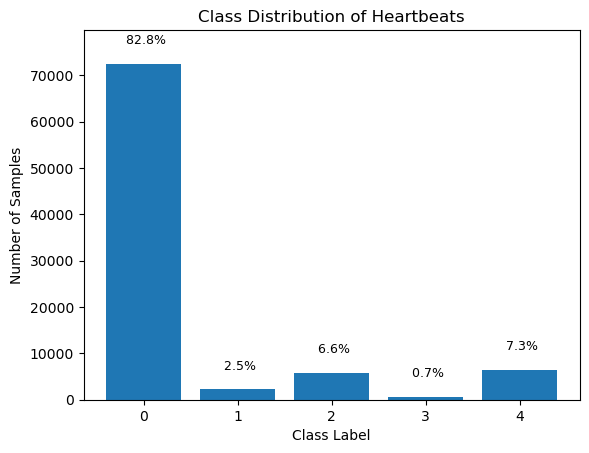

In [76]:
plot_class_distributions(y=y, 
                         title="Class Distribution of Heartbeats",
                         xlabel="Class Label",
                         ylabel="Number of Samples",)

-- Plotting Samples from each Class before Normalisation

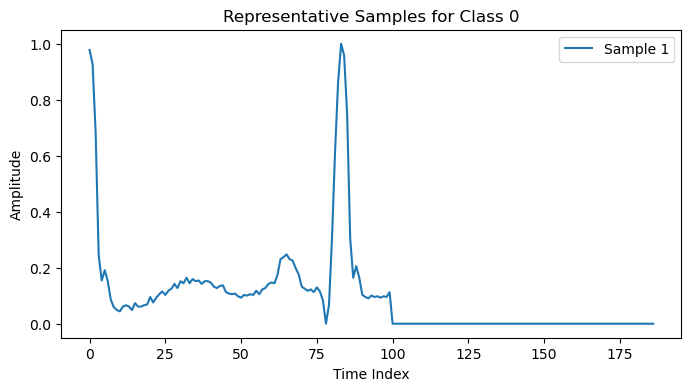

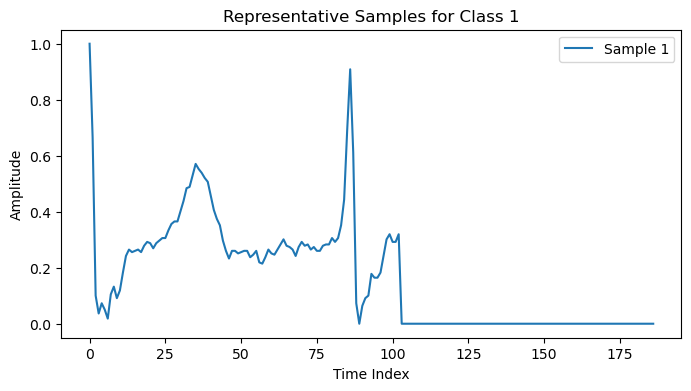

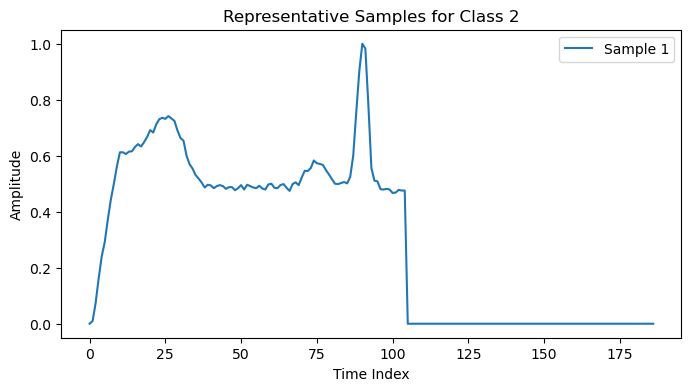

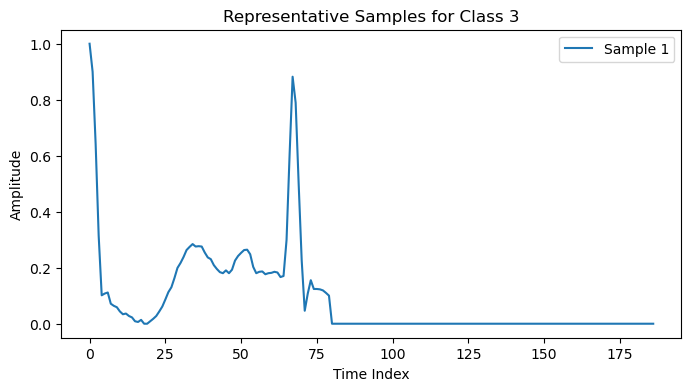

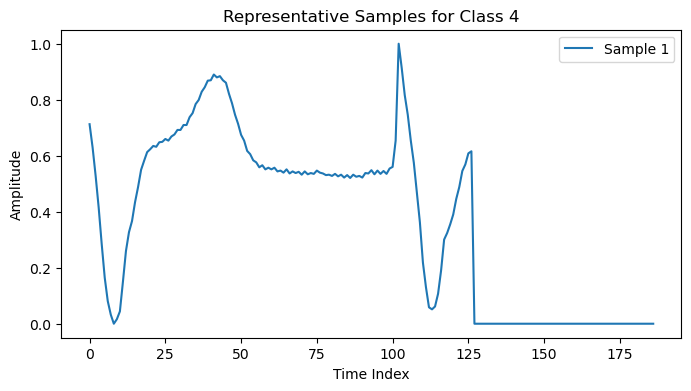

In [77]:
plot_unique_class_samples(X,y,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(8,4))

**Data Preprocessing**

In [78]:
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm

from utils.data import sample
from utils.preprocessing import apply_low_pass_filter, apply_band_pass_filter

In [79]:
X_preprocessed = np.copy(X)

-- Denoising using a Low-Pass Filter  
  
  Reason: Removes muscle artifact and smoothing.

In [ ]:
for i in tqdm(range(X.shape[0]), desc="Applying Low Pass Filter", leave=False):

    X_sample = X[i]

    X_preprocessed[i] = apply_low_pass_filter(sample=X_sample,
                          sampling_frequency=125,
                          cutoff_frequency=25,
                          order=3)
    

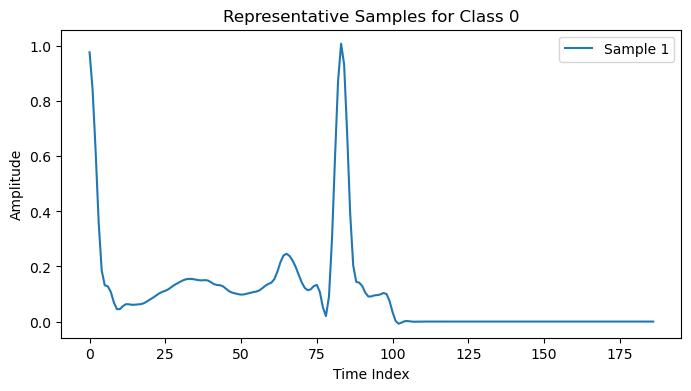

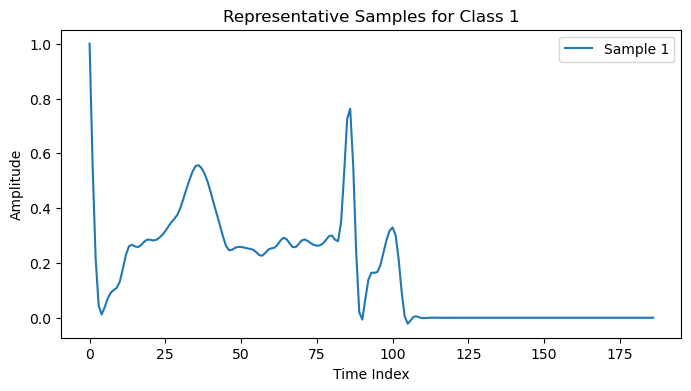

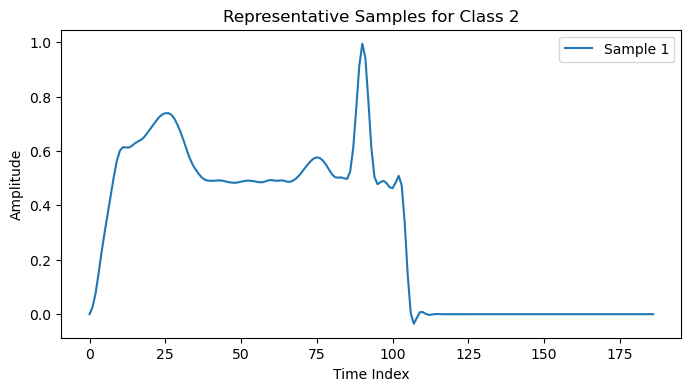

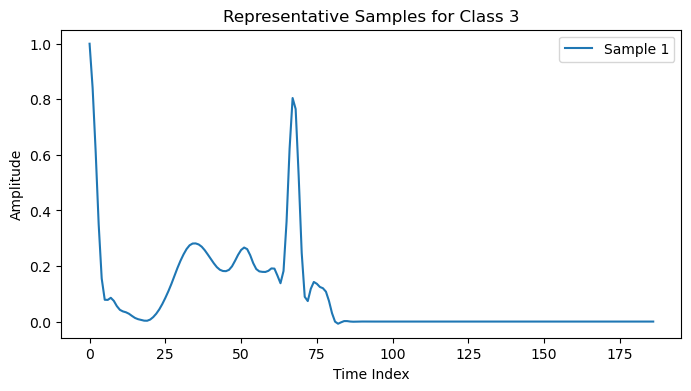

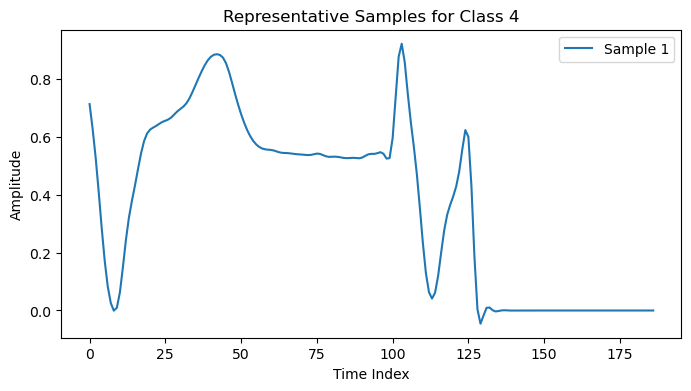

In [81]:
plot_unique_class_samples(X_preprocessed,y,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(8,4))

-- Detecting R-Peaks

In [82]:
from utils.preprocessing import get_r_peak_locations

In [83]:
# We just need a small sample because it will result in a mean close enough to the actual mean
X_samples = sample(X_preprocessed, sample_size_fraction= 0.01, random_state= 42)

print(f"Sampling {len(X_samples)} of {len(X_preprocessed)} samples")
print("--------------------------------------------")

r_peak_indices = get_r_peak_locations(X=X_samples, sampling_rate=125, method="neurokit")

print(f"Mean R_Peak Index: {np.round(np.mean(r_peak_indices).item())}")

Sampling 876 of 87554 samples
--------------------------------------------


 66%|██████▌   | 578/876 [00:01<00:00, 456.51it/s]c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 77%|███████▋  | 673/876 [00:01<00:00, 433.22it/s]c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 92%|█████████▏| 803/876 [00:01<00:00, 410.62it/s]c:\Users\William\miniconda3\envs\neural_networks\lib\site-packages\numpy\_core\fromnumeric

Mean R_Peak Index: 94.0


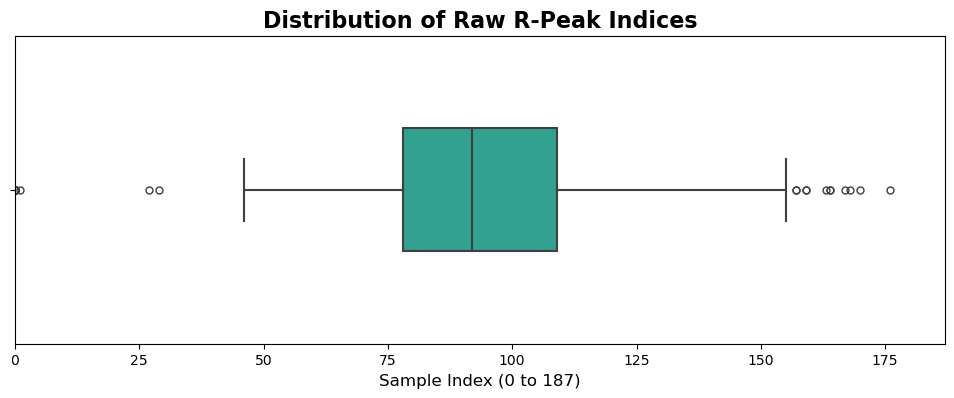

In [84]:
LOWER_LIMIT = 0
UPPER_LIMIT = 187

plt.figure(figsize=(12, 4)) 

sns.boxplot(
    x=r_peak_indices, 
    color="#1fb49b", 
    width=0.4,        
    linewidth=1.5,     
    fliersize=5        
)

plt.xlim(LOWER_LIMIT, UPPER_LIMIT)

plt.title('Distribution of Raw R-Peak Indices', fontsize=16, fontweight='bold')
plt.xlabel('Sample Index (0 to 187)', fontsize=12)

plt.show()

It looks like the data has its R-peak averaging at index 94.  

Hence we will be **shifing the R-peaks to Index 94 (187 / 2)**
  
Reason:  
  1) The primary reason for shifting the R-peaks to symmetrical center of Index 94 is to achieve optimal temporal symmetry for deep learning model stability and feature extraction. 

    By shifting the R to 94, we have more balanced feature set (94 samples before and 93 samples after), and so the model has more context (time steps / samples) to learn the pattern of both the P Q and S, T waves effectively, leading to a faster convergence and higher accuracy 

 

In [85]:
pd.DataFrame(X_preprocessed).head()

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,0.977945,0.840885,0.618158,0.359675,0.185810,0.131881,0.128110,0.107723,0.070109,0.045386,...,1.030505e-19,6.009368e-20,-1.145836e-20,-2.615951e-20,-6.884232e-21,6.414809e-21,5.133861e-21,-1.297713e-22,-1.879169e-21,-7.409829e-22
1,0.960114,0.741616,0.487551,0.250447,0.112349,0.080774,0.093325,0.097488,0.086996,0.075742,...,1.832125e-12,1.290211e-11,4.752906e-12,-2.595231e-12,-2.776433e-12,-2.404598e-13,8.861563e-13,4.566434e-13,-1.237130e-13,-2.141319e-13
2,0.999998,0.583552,0.259139,0.082672,0.037192,0.050347,0.061317,0.056623,0.048907,0.046735,...,2.384981e-21,2.415420e-21,1.639799e-22,-7.898694e-22,-3.891277e-22,1.177680e-22,1.876421e-22,3.673491e-23,-5.131007e-23,-3.454915e-23
3,0.925409,0.701646,0.492098,0.311484,0.175984,0.095629,0.063661,0.058988,0.061500,0.063802,...,-5.949363e-21,6.824935e-21,4.973347e-21,-3.427842e-22,-1.911338e-21,-6.787340e-22,3.950869e-22,4.067388e-22,2.993309e-23,-1.320371e-22
4,0.967132,0.941617,0.822318,0.610835,0.387145,0.222687,0.135782,0.109684,0.117069,0.130458,...,4.719908e-11,-9.196527e-11,-5.529697e-11,9.527282e-12,2.364569e-11,6.517702e-12,-5.674806e-12,-4.693629e-12,5.113128e-14,1.689762e-12


-- R-Peak Alignment and Centering

In [86]:
from utils.preprocessing import linear_alignment_of_r_peak

In [ ]:
for i in tqdm(range(X_preprocessed.shape[0]), leave=False, desc="Performing Linear Alignment"):

    X_sample = X_preprocessed[i]

    X_preprocessed[i] = linear_alignment_of_r_peak(sample=X_sample,
                                      sampling_rate=125,
                                      target_index=94,
                                      method="neurokit")

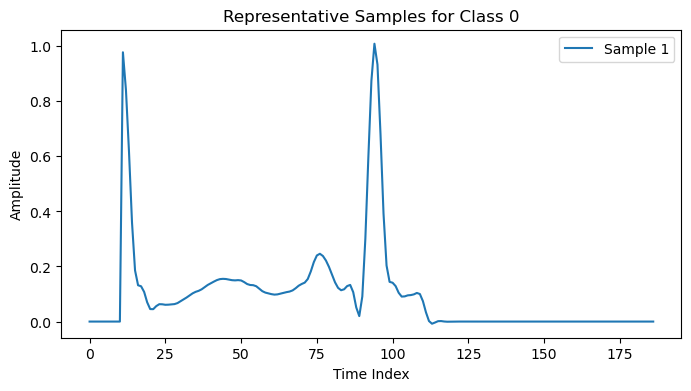

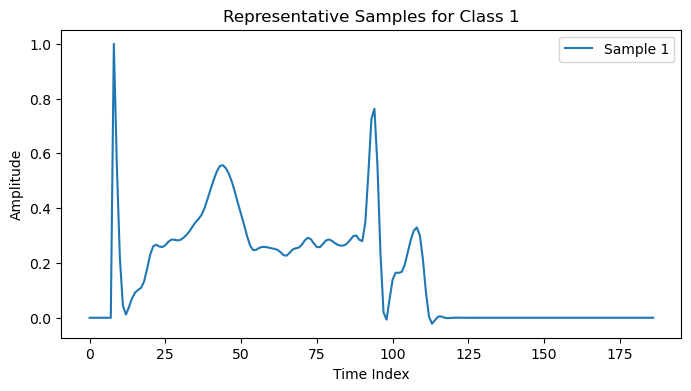

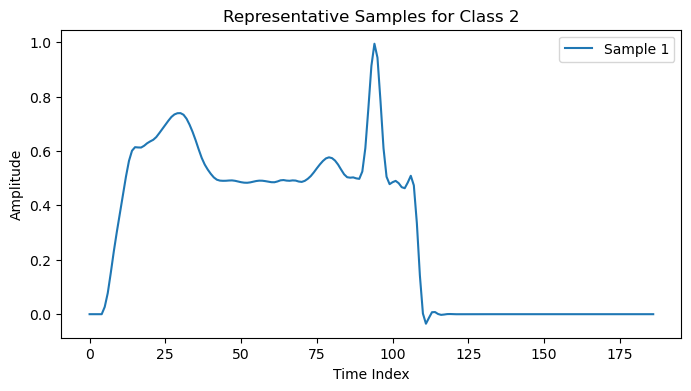

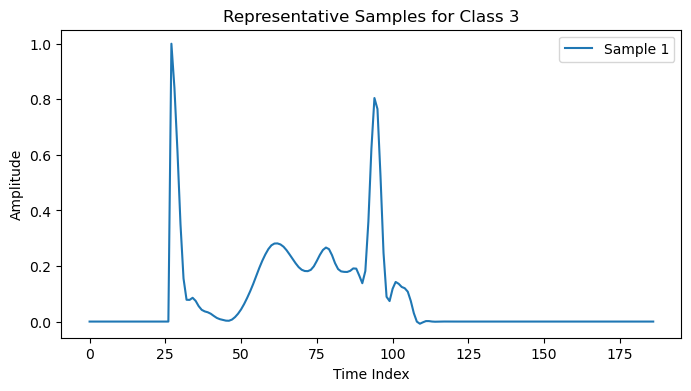

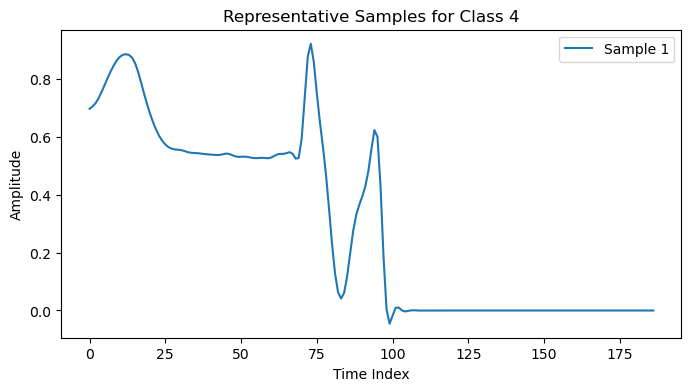

In [88]:
plot_unique_class_samples(X_preprocessed,y,num_samples=1,
                          xlabel="Time Index",
                          ylabel="Amplitude",
                          figsize=(8,4))

**Class Imbalance Analysis and Weight Calculation**  
  
We saw how the classes were imbalanced  
Hence for the training we will calculate class weights for each label.  
  
We will make use of a Random Weighted Sampler and use it in our dataloaders  
  
We used the inverse frequency of each class to compute the weights. Rarers classes would hence have higher weightage and would be sampled more often

In [89]:
import torch
from utils.data import calculate_class_weights

In [90]:
labels, class_weights = calculate_class_weights(y)

print("------------The Class Weights are as follows ----------\n")
for (label, weight) in zip(labels, class_weights):
    print(f"Class {label}: {weight}")

------------The Class Weights are as follows ----------

Class 0: 1.3798622897434835e-05
Class 1: 0.000449842555105713
Class 2: 0.00017277125086385625
Class 3: 0.0015600624024961
Class 4: 0.00015549681231534753


In [104]:
# Saving Preprocessed (Train + Val) Data 
np.savez(
    "data/ecg_preprocessed_train_val.npz",
    X = X_preprocessed,
    y = y,
    sample_freq=125,
    cutoff_freq=25,
    target_r_peak_index=94,
)

**TRAINING MODELS**

In [93]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import WeightedRandomSampler

In [ ]:
# load pre processed data
data_path = "data/ecg_preprocessed_train_val.npz"
data = np.load(data_path)

X = data["X"]
y = data["y"]

class_weights = data["class_weights"]

# assign the weights to all of y_train
train_sample_weights = np.array(class_weights)[y]

train_sample_weights = torch.from_numpy(train_sample_weights).float()

weighted_sampler = WeightedRandomSampler(
    weights= train_sample_weights,
    num_samples= len(train_sample_weights),
    replacement=True,
)

NUM_CLASSES = len(class_weights)

**RNNS**: biLSTM

In [101]:
from torch import nn
from torchmetrics import F1Score, AUROC, Precision, Recall

from utils.torch_classes import ECG_Dataset
from torch.utils.data import DataLoader
from utils.rnn_models import ECG_LSTM_Classifier
from utils.rnn_models import ECG_GRU_Classifier

from utils.torch_classes import EarlyStopping
from utils.train import train_and_eval_model, val_loop
from utils.logging import log_to_json, log_to_csv

import numpy as np
import random
import time

In [102]:
# Creating Datasets

X_train, X_val, y_train,y_val = train_test_split(X,y,
                                                 test_size=0.2,
                                                 random_state=42,
                                                 stratify=y)

train_dataset = ECG_Dataset(X=X_train, y=y_train)
val_dataset = ECG_Dataset(X=X_val, y=y_val)

-- Sanity Check LSTM

In [ ]:
from utils.train import train_and_eval_model

train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=128,
            sampler= weighted_sampler, # this is the Random Weighted Sampler we had created earlier 
            shuffle= False # we dont need to shuffle because we are using the sampler
        )

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=128,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = ECG_LSTM_Classifier(input_size=1,
                            hidden_size=32,
                            num_layers=1,
                            num_classes=NUM_CLASSES,
                            dropout=0.2,
                            bidirectional=True)

model.to(device)

results = train_and_eval_model(model=model,
                     loss_fn= torch.nn.CrossEntropyLoss(),
                     optimizer=torch.optim.Adam(model.parameters()),
                     train_dataloader=train_dataloader,
                     val_dataloader=val_dataloader,
                     early_stopper=EarlyStopping(patience=1,delta=0,verbose=True,checkpoint_path="sanity_check/best_lstm.pt"),
                     verbose=True,
                     epochs=5,
                     device=device
                     )

print(results)

-- Sanity Check GRU

In [ ]:
model = ECG_GRU_Classifier(input_size=1,
                            hidden_size=32,
                            num_layers=1,
                            num_classes=NUM_CLASSES,
                            dropout=0.2,
                            bidirectional=True)

model.to(device)

train_and_eval_model(model=model,
                     loss_fn= torch.nn.CrossEntropyLoss(),
                     optimizer=torch.optim.Adam(model.parameters()),
                     train_dataloader=train_dataloader,
                     val_dataloader=val_dataloader,
                     early_stopper=EarlyStopping(patience=1,delta=0,verbose=True,checkpoint_path="sanity_check/best_gru.pt"),
                     verbose=True,
                     epochs=5,
                     device=device
                     )

print(results)

-- HYPERPARAM Tuning

In [ ]:
from sklearn.model_selection import ParameterSampler

EXPERIMENTS = 60

param_grid = {
    "model": ["LSTM", "GRU"],
    "bidirectional": [True, False],
    "optimizer": ["Adam", "AdamW", "SGD"],
    "momentum": np.linspace(0.9,0.999,3).tolist(),
    "batch_size": [32,64,128],
    "hidden_size": [32,64,128,256],
    "num_layers": [1,2,3],
    "dropout": [0.1,0.2,0.3,0.5],
    "weight_decay": np.logspace(-5,-2,num=5).tolist(),
    "learning_rate": np.logspace(-4,-2,num=10).tolist(),
}

configs = list(ParameterSampler(
    param_grid, 
    n_iter=EXPERIMENTS, 
    random_state=42))

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

LOG_FOLDER = "random_search_results"
EPOCHS = 15

device = "cuda" if torch.cuda.is_available() else "cpu"

results_summary_json = []
results_summary_csv = []

val_precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
val_recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
val_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
val_auc_metric = AUROC(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)

for i, params in enumerate(configs):

  
    try: 
        # RESET METRICS
        val_precision_metric.reset()
        val_recall_metric.reset()
        val_f1_metric.reset()
        val_auc_metric.reset()

        print(f"-------------- Experiment {i + 1} ----------------")

        BATCH_SIZE = params['batch_size']
        OPTIM = params['optimizer']

        INPUT_SIZE = 1
        HIDDEN_SIZE = params["hidden_size"]
        NUM_LAYERS = params["num_layers"]
        DROPOUT = params["dropout"]
        BIDIRECTIONAL = params["bidirectional"]

        MOMENTUM = params["momentum"]
        LEARNING_RATE = params["learning_rate"]
        WEIGHT_DECAY = params["weight_decay"]

        MODEL = params['model']

        print(f"Model: {'Bi' if BIDIRECTIONAL else ''}{MODEL}")

# ----------------------------------------------------
        # We need to recreate the data loaders 
        train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=BATCH_SIZE,
            sampler= weighted_sampler, # this is the Random Weighted Sampler we had created earlier 
            shuffle= False # we dont need to shuffle because we are using the sampler
        )

        val_dataloader = DataLoader(
            dataset=val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False
        )

# ----------------------------------------------------
        # Create the Model 
        if MODEL == "LSTM":
            model = ECG_LSTM_Classifier(
                input_size=INPUT_SIZE,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                num_classes=NUM_CLASSES,
                dropout=DROPOUT,
                bidirectional=BIDIRECTIONAL
            )

        elif MODEL == "GRU":
            model = ECG_GRU_Classifier(
                input_size=INPUT_SIZE,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                num_classes=NUM_CLASSES,
                dropout=DROPOUT,
                bidirectional=BIDIRECTIONAL
            )
        model.to(device)
# ----------------------------------------------------
        # Create the optimiers 
        if OPTIM == "Adam":
            optim = torch.optim.Adam(params=model.parameters(),
                                    lr=LEARNING_RATE,
                                    weight_decay=WEIGHT_DECAY)

        elif OPTIM == "AdamW":
            optim = torch.optim.AdamW(params=model.parameters(),
                                    lr=LEARNING_RATE,
                                    weight_decay=WEIGHT_DECAY)
            
        elif OPTIM == "SGD":
            optim = torch.optim.SGD(params=model.parameters(),
                                    lr=LEARNING_RATE,
                                    momentum=MOMENTUM,
                                    weight_decay=WEIGHT_DECAY)

        else: 
            raise ValueError(f"Unknown optimizer: {OPTIM}")
# ----------------------------------------------------

        # Create Loss function
        loss_func = nn.CrossEntropyLoss()

        # Create Early Stopper
        early_stopper = EarlyStopping(
                patience=5, 
                delta=0,
                checkpoint_path=f"{LOG_FOLDER}/checkpoints/experiment_{i+1}.pt",
                verbose=False)

# ----------------------------------------------------
        start = time.time()
        results = train_and_eval_model(
            model=model, 
            loss_fn=loss_func,
            optimizer=optim,
            device=device,

            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            
            epochs=EPOCHS, # small epoch number during this phase
            early_stopper= early_stopper,

            verbose=False,
            debug=False
        )
        end = time.time()

        epochs_run = len(results["train_loss"])

        total_time = (end-start)
        time_per_epoch = total_time/epochs_run if epochs_run > 0 else 0 # (i+1) is the current epoch

# ----------------------------------------------------
        model.load_state_dict(torch.load(early_stopper.checkpoint_path, map_location=device)["model_state_dict"])
        best_val_data = val_loop(model=model, 
                                 val_dataloader=val_dataloader,
                                 loss_fn=loss_func, 
                                 device=device)
        
        best_val_pred = torch.cat(best_val_data["y_pred"])
        best_val_true = torch.cat(best_val_data["y_true"])

        best_val_pred_logits = torch.cat(best_val_data["y_pred_logits"])

        # Calculate Precision
        best_val_precision = val_precision_metric(best_val_pred.to(device), best_val_true.to(device)).item()

        # Calculate Recall
        best_val_recall = val_recall_metric(best_val_pred.to(device), best_val_true.to(device)).item()

        # Calculate the F1 score 
        best_val_f1 = val_f1_metric(best_val_pred.to(device),best_val_true.to(device)).item()
        
        # Calculate the AUC
        best_val_auc = val_auc_metric(best_val_pred_logits.to(device),best_val_true.to(device)).item()

# ----------------------------------------------------
        # Update Results Summary
        results_summary_csv.append({
            "experiment": i+1,
            **params,
            "epochs run": epochs_run,
            "total epochs": EPOCHS,
            "final_train_loss": results["train_loss"][-1],
            "final_val_loss": results["val_loss"][-1],
            "min_val_loss": early_stopper.val_loss_min,
            "best_val_precision": best_val_precision,
            "best_val_recall": best_val_recall,
            "best_val_f1": best_val_f1,
            "best_val_auc": best_val_auc,
            "total_time": total_time,
            "time_per_epoch": time_per_epoch
        })


        results_summary_json.append({
            "experiment": i + 1,
            "params": params,
            "train_loss": results['train_loss'],
            "val_loss": results['val_loss']
        }) 

        # Lets log the results
        log_to_csv(filepath="random_search_results/results.csv",
            content=results_summary_csv)

        log_to_json(filepath="random_search_results/results.json",
            content=results_summary_json)
        
        print(f"Epochs Run: {epochs_run} / {EPOCHS} {'(Early Stop)' if early_stopper.early_stop else ''}")
        print(f"Total Time: {total_time:.3f} secs")
        print(f"Average Time Per Epoch: {time_per_epoch:.3f} s")
        print(f"Min Val Loss: {early_stopper.val_loss_min:.3f} | Best F1 Score: {best_val_f1:.3f} | Best AUC Score: {best_val_auc:.3f}")

        print("\n")

    except Exception as e:
        print(f"Experiment {i + 1} Failed ! : {e}")

print("---------------- All Experiments Completed --------------")